# 学习率调度器


In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l

'''
定义了一个LeNet架构的卷积神经网络
输入：1×28×28的Fashion-MNIST灰度图像
输出：10个类别的概率分布
特点：经典LeNet结构，含2个卷积层+池化层+3个全连接层
'''
def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(), # 输入1通道，输出6通道，5×5卷积
        nn.MaxPool2d(kernel_size=2, stride=2), # 2×2最大池化
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(), #  6通道→16通道,5×5卷积
        nn.MaxPool2d(kernel_size=2, stride=2), # 2×2最大池化
        nn.Flatten(), # 展平为一维向量
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(), # 全连接层：16×5×5→120
        nn.Linear(120, 84), nn.ReLU(), # 全连接层：120→84
        nn.Linear(84, 10)) # 输出层：84→10类

    return model

loss = nn.CrossEntropyLoss() # 交叉熵损失函数（分类任务）
device = d2l.try_gpu() # 优先使用GPU，否则用CPU

batch_size = 256 # 批次大小
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size) # 加载数据集

# 代码几乎与d2l.train_ch6定义在卷积神经网络一章LeNet一节中的相同
'''
net:神经网络模型
train_iter/test_iter:训练和测试数据迭代器
num_epochs:训练轮数
loss:损失函数
trainer:优化器（如SGD、Adam）
device:训练设备
scheduler:学习率调度器
'''
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__: # PyTorch内置调度器
                # UsingPyTorchIn-Builtscheduler
                scheduler.step()
            else: # 自定义调度器（以epoch为参数）
                # Usingcustomdefinedscheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

让我们来看看如果使用默认设置，调用此算法会发生什么。
例如设学习率为$0.3$并训练$30$次迭代。
留意在超过了某点、测试准确度方面的进展停滞时，训练准确度将如何继续提高。
两条曲线之间的间隙表示过拟合。


train loss 0.144, train acc 0.945, test acc 0.893


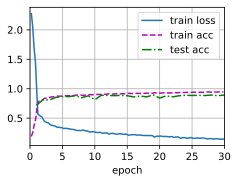

In [2]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## 学习率调度器

我们可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。
例如，以动态的方式来响应优化的进展情况。


In [3]:
lr = 0.1
'''
将优化器的学习率强制设置为lr
trainer是 PyTorch 优化器（如 SGD、Adam）的实例
trainer.param_groups是一个列表，存储所有参数组,每个参数组是一个字典，包含以下关键字段：
'params':该组的所有可训练参数
'lr':该组的学习率
'weight_decay':权重衰减系数等
[0]：访问第一个参数组（通常所有参数都在这一个组里）
["lr"]：访问该参数组的"学习率"配置项
'''
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


$\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$。


In [4]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

让我们在一系列值上绘制它的行为。


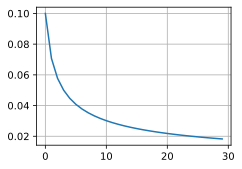

In [5]:
scheduler = SquareRootScheduler(lr=0.1)
'''
torch.arange(num_epochs)：生成x轴数据，[0,1,2,...,num_epochs-1]
[scheduler(t) for t in range(num_epochs)]：列表推导式，对每个epoch t调用调度器计算出对应的学习率，生成y轴数据
'''
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

现在让我们来看看这对在Fashion-MNIST数据集上的训练有何影响。
我们只是提供调度器作为训练算法的额外参数。


train loss 0.275, train acc 0.900, test acc 0.874


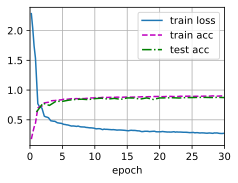

In [6]:
'''
网络创建 → 优化器配置 → 启动训练
   ↓           ↓            ↓
net_fn() → SGD(net.params) → train(...)
'''
net = net_fn()
# net.parameters()：传入网络中所有可训练的参数（权重和偏置）
# lr：使用之前设置的初始学习率（如 0.1）
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, # 要训练的LeNet网络
      train_iter, # 训练数据迭代器（Fashion-MNIST）
      test_iter, # 测试数据迭代器
      num_epochs, # 训练轮数（如10轮）
      loss, # 损失函数（CrossEntropyLoss）
      trainer, # SGD优化器
      device, # 训练设备（GPU或CPU）
      scheduler) # 学习率调度器（SquareRootScheduler）

### 单因子调度器

多项式衰减的一种替代方案是乘法衰减，即$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$其中$\alpha \in (0, 1)$。
为了防止学习率衰减到一个合理的下界之下，
更新方程经常修改为$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。


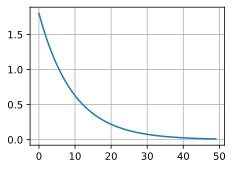

In [7]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor # 衰减因子（通常设为0.9或0.95）
        self.stop_factor_lr = stop_factor_lr # 学习率下限（保护机制）
        self.base_lr = base_lr # 当前学习率（会动态变化）

    def __call__(self, num_update):
        '''
        将当前学习率乘以衰减因子self.factor
        与下限self.stop_factor_lr取最大值（防止过低）
        更新并返回新的学习率
        '''
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
# x轴：0到49的epoch数;y轴：每个epoch对应的学习率
# 效果：由于base_lr动态更新，曲线呈指数衰减特性
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

### 多因子调度器

训练深度网络的常见策略之一是保持学习率为一组分段的常量，并且不时地按给定的参数对学习率做乘法衰减。
具体地说，给定一组降低学习率的时间点，例如$s = \{5, 10, 20\}$，
每当$t \in s$时，降低$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$。
假设每步中的值减半，我们可以按如下方式实现这一点。


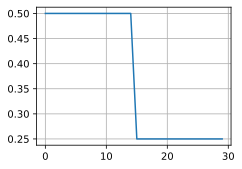

In [8]:
net = net_fn() # 网络：创建LeNet模型
trainer = torch.optim.SGD(net.parameters(), lr=0.5) # 优化器：SGD，初始学习率0.5
# 调度器：MultiStepLR 在指定 epoch 触发学习率衰减
# milestones=[15, 30]：在第15和30个epoch时触发;gamma=0.5：触发时，学习率乘以0.5
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0] # ① 获取当前学习率
    trainer.step() # ② 更新优化器
    scheduler.step() # ③ 推进调度器
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

这种分段恒定学习率调度背后的直觉是，让优化持续进行，直到权重向量的分布达到一个驻点。
此时，我们才将学习率降低，以获得更高质量的代理来达到一个良好的局部最小值。
下面的例子展示了如何使用这种方法产生更好的解决方案。


train loss 0.205, train acc 0.923, test acc 0.893


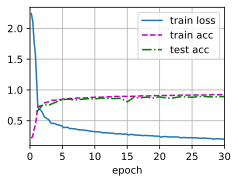

In [9]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 余弦调度器

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$
这里$\eta_0$是初始学习率，$\eta_T$是当$T$时的目标学习率。此外，对于$t > T$，我们只需将值固定到$\eta_T$而不再增加它。在下面的示例中，我们设置了最大更新步数$T = 20$。<br>
$lr_{warmup}(t)=lr_{begin}+(lr_{orig}-lr_{begin})\times \frac{t}{warmup\underline{~}steps}$<br>
$lr_{cosine}(t)=lr_{final}+\frac{lr_{orig}-lr_{final}}{2}\times [1+cos(π\times \frac{t-warmup\underline{~}steps}{max\underline{~}steps} )]$ 

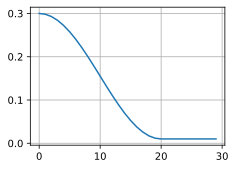

In [10]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr # 初始学习率（备份）
        self.max_update = max_update # 最大更新次数（总训练epoch）
        self.final_lr = final_lr # 余弦退火的最终学习率
        self.warmup_steps = warmup_steps # Warmup阶段步数
        self.warmup_begin_lr = warmup_begin_lr # Warmup起始学习率
        self.max_steps = self.max_update - self.warmup_steps # 余弦阶段总步数

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        # Warmup阶段：线性增加
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        # 余弦退火阶段
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr
# 无Warmup（默认warmup_steps=0）,总训练20轮,学习率从0.3衰减到0.01
scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

在计算机视觉的背景下，这个调度方式可能产生改进的结果。
但请注意，如下所示，这种改进并不一定成立。


train loss 0.196, train acc 0.928, test acc 0.893


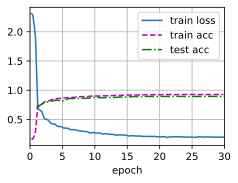

In [11]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 预热


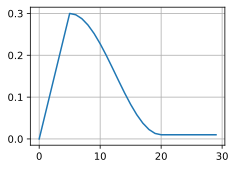

In [12]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

注意，观察前5个迭代轮数的性能，网络最初收敛得更好。


train loss 0.186, train acc 0.932, test acc 0.900


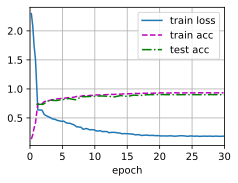

In [13]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)